In [24]:
from pykrx import stock
from pykrx import bond

In [25]:
import pandas as pd

# 세 개의 DataFrame 생성
df_ohlcv = stock.get_market_ohlcv("20220101", "20231231", "005930")
df_fundamental = stock.get_market_fundamental("20220101", "20231231", "005930")
df_foreign_investment = stock.get_exhaustion_rates_of_foreign_investment("20220101", "20231231", "005930")

# 열 기준으로 결합
df_combined = pd.concat([df_ohlcv, df_fundamental, df_foreign_investment], axis=1, join="inner")

df_combined.to_csv("your_data.csv", encoding="utf-8-sig", index=True)

# 결과 확인
print(df_combined.head(3))




               시가     고가     저가     종가       거래량       등락률    BPS    PER  \
날짜                                                                         
2022-01-03  79400  79800  78200  78600  13502112  0.383142  39406  20.46   
2022-01-04  78800  79200  78300  78700  12427416  0.127226  39406  20.49   
2022-01-05  78800  79000  76400  77400  25470640 -1.651842  39406  20.15   

             PBR   EPS   DIV   DPS       상장주식수        보유수량       지분율  \
날짜                                                                     
2022-01-03  1.99  3841  3.81  2994  5969782550  3099478430  51.90625   
2022-01-04  2.00  3841  3.80  2994  5969782550  3102550526  51.96875   
2022-01-05  1.96  3841  3.87  2994  5969782550  3103048671  51.96875   

                  한도수량     한도소진률  
날짜                                
2022-01-03  5969782550  51.90625  
2022-01-04  5969782550  51.96875  
2022-01-05  5969782550  51.96875  


### Test

In [26]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
data = pd.read_csv("your_data.csv")

# 데이터 전처리
data['날짜'] = pd.to_datetime(data['날짜'])
data = data.sort_values('날짜')
scaler = MinMaxScaler()
data[['종가', '고가', 'PER', '보유수량']] = scaler.fit_transform(data[['종가', '고가', 'PER', '보유수량']])

# 학습/테스트 데이터 분할
train_data = data[(data['날짜'] >= '2022-01-01') & (data['날짜'] <= '2023-06-30')]
test_data = data[(data['날짜'] >= '2023-07-01') & (data['날짜'] <= '2023-12-31')]

X_train = []
y_train = []
X_test = []
y_test = []

# 시계열 데이터 준비 (15일을 기준으로 입력 데이터 생성)
window_size = 15

for i in range(window_size, len(train_data)):
    X_train.append(train_data[['고가', 'PER', '보유수량']].values[i-window_size:i])
    y_train.append(train_data['종가'].values[i])

for i in range(window_size, len(test_data)):
    X_test.append(test_data[['고가', 'PER', '보유수량']].values[i-window_size:i])
    y_test.append(test_data['종가'].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# 모델 정의
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# 예측
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], 3))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1))[:, 0]

# 예측 결과와 실제 값 비교
predicted_vs_actual = pd.DataFrame({'Actual': y_test_actual, 'Predicted': predicted_prices})
print(predicted_vs_actual.head())


/home/yim/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - loss: 0.0707 - val_loss: 0.0122
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0221 - val_loss: 0.0192
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0056 - val_loss: 0.0170
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0060 - val_loss: 0.0069
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0033 - val_loss: 0.0123
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0028 - val_loss: 0.0083
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0028 - val_loss: 0.0100
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0028 - val_loss: 0.0064
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0024 - val_loss: 0.0077

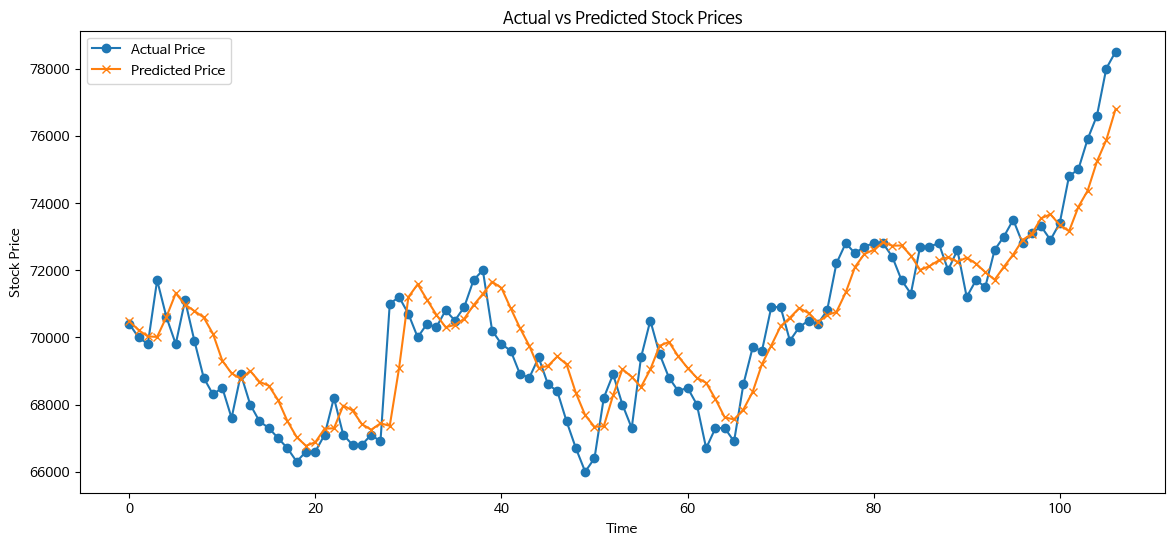

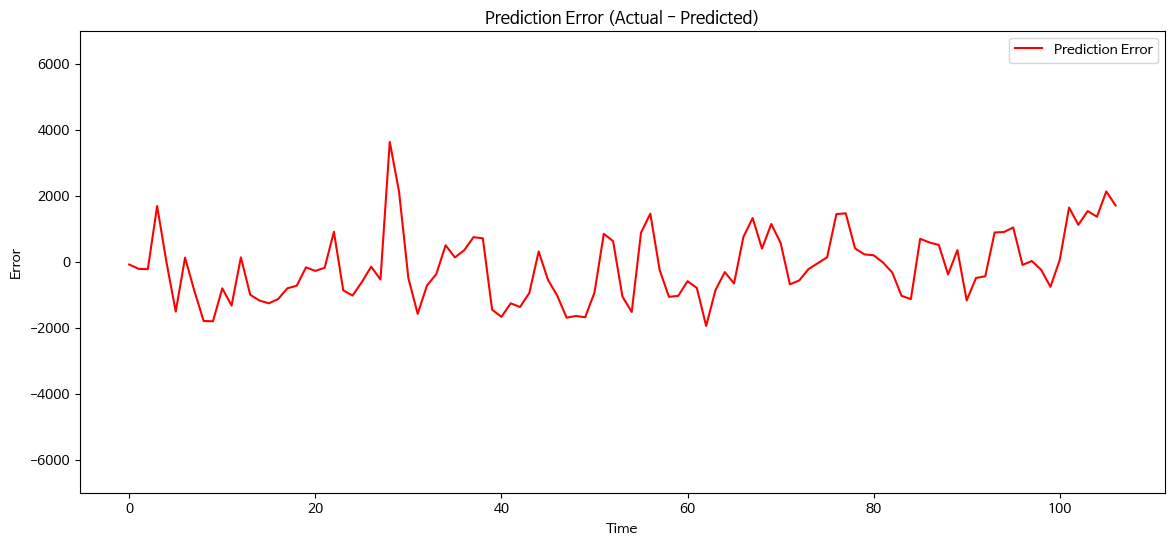

In [27]:
import matplotlib.pyplot as plt

# 오차 계산
predicted_vs_actual['Error'] = predicted_vs_actual['Actual'] - predicted_vs_actual['Predicted']

# 예측 값과 실제 값 비교 그래프
plt.figure(figsize=(14, 6))
plt.plot(predicted_vs_actual['Actual'], label='Actual Price', marker='o')
plt.plot(predicted_vs_actual['Predicted'], label='Predicted Price', marker='x')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 오차 그래프
plt.figure(figsize=(14, 6))
plt.plot(predicted_vs_actual['Error'], label='Prediction Error', color='red')
plt.ylim(-7000, 7000)
plt.title('Prediction Error (Actual - Predicted)')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()


### Predict 2024 (for 50 days)

In [28]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드
data = pd.read_csv("your_data.csv")

# 데이터 전처리
data['날짜'] = pd.to_datetime(data['날짜'])
data = data.sort_values('날짜')
scaler = MinMaxScaler()
data[['종가', '고가', 'PER', '보유수량']] = scaler.fit_transform(data[['종가', '고가', 'PER', '보유수량']])

# 학습 데이터 준비 (2019년부터 2023년까지)
train_data = data[(data['날짜'] >= '2022-01-01') & (data['날짜'] <= '2023-12-31')]

X_train = []
y_train = []
window_size = 15

for i in range(window_size, len(train_data)):
    X_train.append(train_data[['고가', 'PER', '보유수량']].values[i-window_size:i])
    y_train.append(train_data['종가'].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# 모델 정의
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=50, batch_size=64)

# 2024년 예측 준비
# 마지막 15일 데이터로부터 50일 데이터를 순차적으로 예측
predicted_prices = []
last_window = train_data[['고가', 'PER', '보유수량']].values[-window_size:]

for day in range(50):  # 50일 예측
    x_input = last_window.reshape((1, window_size, 3))
    predicted_price = model.predict(x_input)
    
    predicted_prices.append(predicted_price[0][0])
    
    # 예측한 값을 윈도우에 추가하여 다음 예측에 사용
    last_window = np.append(last_window[1:], [[predicted_price[0][0], last_window[-1][1], last_window[-1][2]]], axis=0)

# 예측 결과 스케일 원상 복구
predicted_prices = scaler.inverse_transform(np.concatenate((np.array(predicted_prices).reshape(-1, 1), 
                                                           np.zeros((50, 3))), axis=1))[:, 0]

# 예측 결과 출력
predicted_2024 = pd.DataFrame({
    '날짜': pd.date_range(start='2024-01-01', periods=50, freq='B'),  # 주말 및 휴일 제외한 영업일 기준
    '예측_종가': predicted_prices
})
print(predicted_2024.head())


/home/yim/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 0.1709
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0340
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0121
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0066
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0066
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0045
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0044
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0042
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0039
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0037
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0032
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0035
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0032
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0032
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━

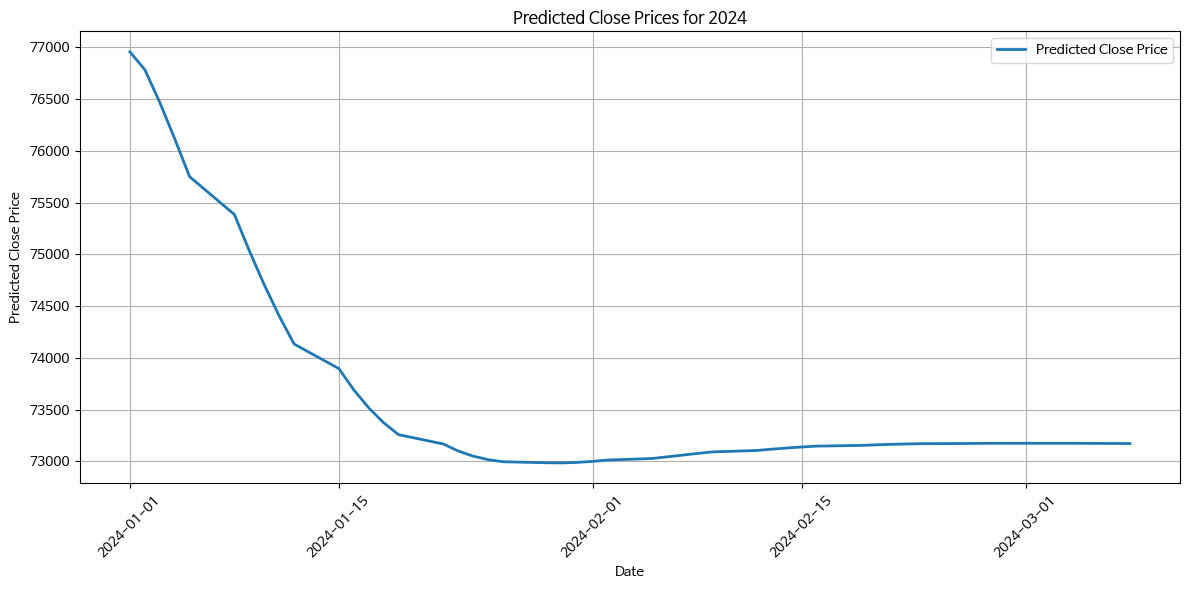

In [29]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(12, 6))
plt.plot(predicted_2024['날짜'], predicted_2024['예측_종가'], label='Predicted Close Price', linewidth=2)

# 그래프 제목과 라벨 설정
plt.title("Predicted Close Prices for 2024")
plt.xlabel("Date")
plt.ylabel("Predicted Close Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 날짜 라벨을 기울여서 표시

# 그래프 표시
plt.tight_layout()
plt.show()
